# Loading data and working with target variable

In [2]:
import datetime

import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
data = pd.read_csv(
    'data/SBER.txt', 
    usecols=['<DATE>', '<TIME>', '<CLOSE>', '<VOL>'],
    parse_dates=[['<DATE>', '<TIME>']],
    dayfirst=True
)
data.columns = ['datetime', 'close', 'vol']
data.set_index('datetime', inplace=True)

data.tail()

,close,vol
datetime,,
2020-10-30 23:45:00,200.98,20080
2020-10-30 23:46:00,201.00,13710
2020-10-30 23:47:00,200.96,8550
2020-10-30 23:48:00,200.96,34070
2020-10-30 23:49:00,200.99,72420


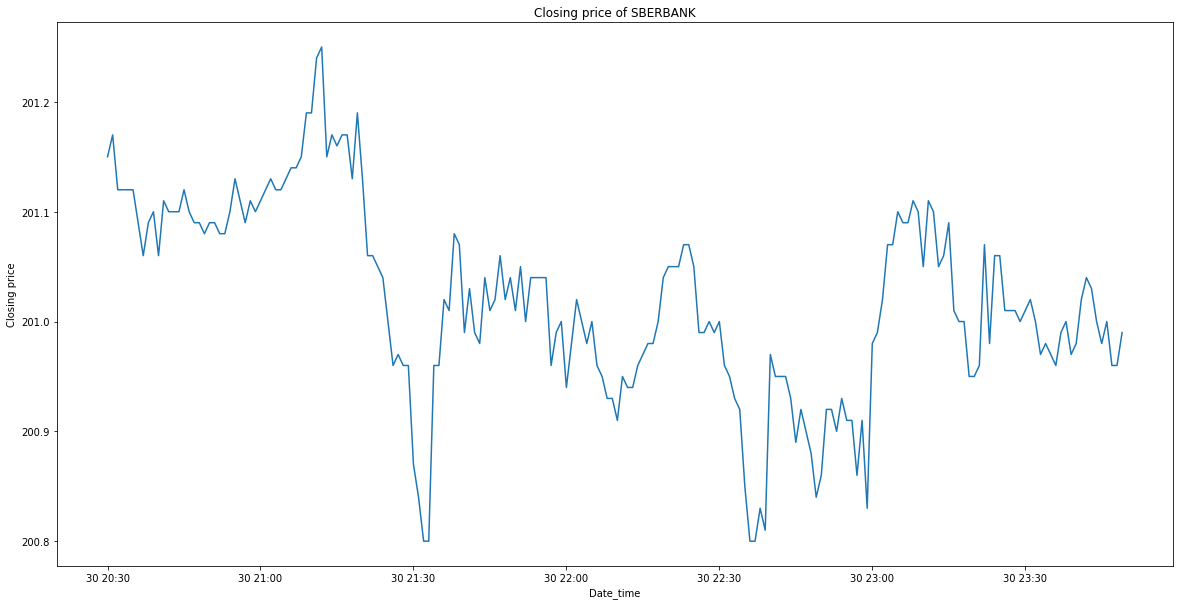

In [3]:
plt.plot(data.close[-200:])
plt.title('Closing price of SBERBANK')
plt.ylabel('Closing price')
plt.xlabel('Date_time')
plt.grid(False)
plt.show()

In [4]:
data['returns_per_hour'] = data.close.pct_change(periods=60).shift(-60)
data.head(6)

,close,vol,returns_per_hour
datetime,,,
2009-01-11 10:30:00,23.01,666517,0.005215
2009-01-11 10:31:00,23.02,199410,0.005647
2009-01-11 10:32:00,23.20,523289,-0.002155
2009-01-11 10:33:00,23.22,283141,-0.003876
2009-01-11 10:34:00,23.24,211039,-0.003873
2009-01-11 10:35:00,23.14,535577,0.000432


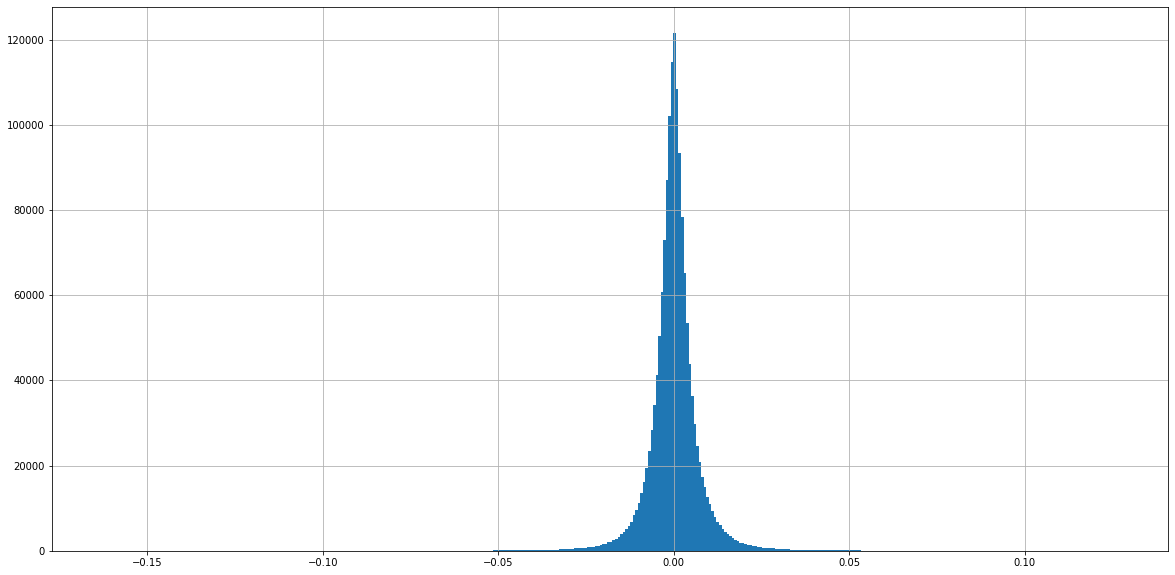

In [5]:
data.returns_per_hour.hist(bins=400)

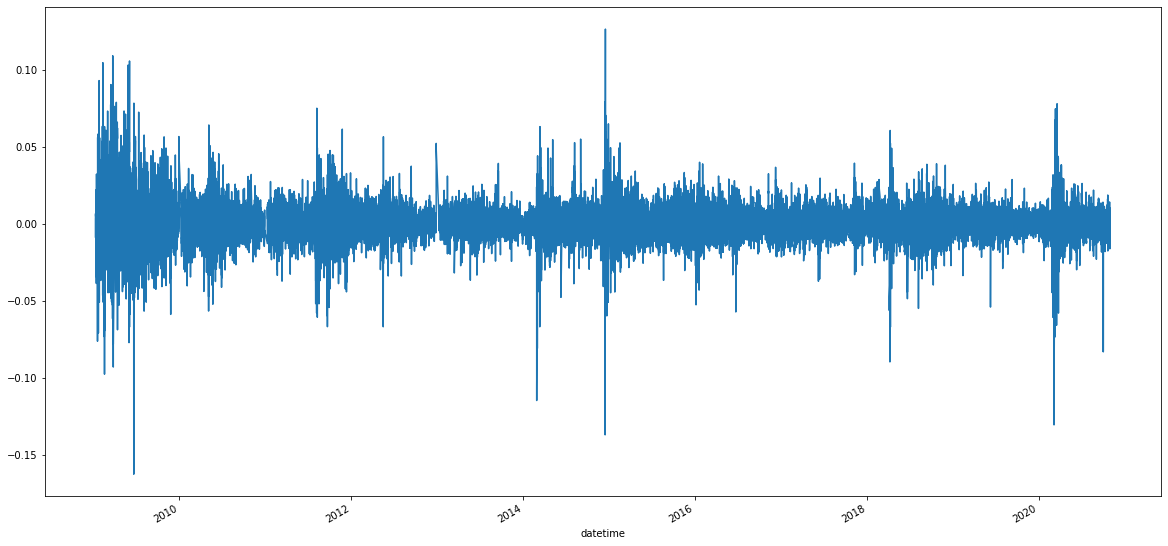

In [6]:
data.returns_per_hour.plot()

# Working with news

#### Cleaning parsed news

In [3]:
news = pd.read_csv('data/full_news.csv')

news.head()

,datetime,title,text
0,7 часов назад (13.11.2020 23:25),"Рынок акций США закрылся ростом, Dow Jones пр...","<div class=""WYSIWYG articlePage"">\n <di..."
1,15 часов назад (13.11.2020 15:40),"Евраз объединяет угольный бизнес в Распадской,...","<div class=""WYSIWYG articlePage"">\n <di..."
2,14 часов назад (13.11.2020 17:18),"Cisco, Walt Disney и DraftKings выросли на пре...","<div class=""WYSIWYG articlePage"">\n <di..."
3,14 часов назад (13.11.2020 16:22),Рынок акций Московской биржи по состоянию на 1...,"<div class=""WYSIWYG articlePage"">\n <di..."
4,14 часов назад (13.11.2020 16:52),"Трамп запретил инвестиции в китайские фирмы, с...","<div class=""WYSIWYG articlePage"">\n <di..."


In [4]:
"""
Cleanes the text column from HTML markup, source of news,
\n, \r, \t and excess spaces
"""

news.text = news.text.apply(
    lambda x: re.sub(
        '<[^<]+?>|\n|\r|\t|© Reuters.|Investing.com — |  +', '', x
    )
)


'''
Extracts date and time
'''
news.datetime = news.datetime.str.extract(
    r'(\d+\.\d+\.\d+ \d+:\d+)'
)

In [5]:
news.to_csv(
    'data/full_news_cleaned.csv', 
    index=False
)

#### Cleaned news

In [6]:
news = pd.read_csv('data/full_news_cleaned.csv')

In [11]:
news.head()

,datetime,title,text
0,13.11.2020 23:25,"Рынок акций США закрылся ростом, Dow Jones пр...","Рынок акцийСША закрылся ростом, Dow Jones приб..."
1,13.11.2020 15:40,"Евраз объединяет угольный бизнес в Распадской,...",МОСКВА (Рейтер) - Российский стальной холдинг ...
2,13.11.2020 17:18,"Cisco, Walt Disney и DraftKings выросли на пре...",На премаркете Нью-Йоркской биржи в пятницу акц...
3,13.11.2020 16:22,Рынок акций Московской биржи по состоянию на 1...,Рынок акций Московской биржи по состоянию на 1...
4,13.11.2020 16:52,"Трамп запретил инвестиции в китайские фирмы, с...",Продолжая свою жесткую политику несмотря на ре...
5,13.11.2020 17:25,Экспорт Газпрома в Европу сократился на 12% до...,St. Petersburg International Economic ForumМО...
6,13.11.2020 17:30,АНАЛИЗ: Неожиданные дефолты могут замедлить пр...,Illustration photo of a China yuan noteСИДНЕЙ...
7,13.11.2020 17:31,Газпром сдвигает срок запуска газохимического ...,МОСКВА (Рейтер) - Российский Газпром сдвигает ...
8,13.11.2020 17:25,Минфин РФ предложил вкладывать средства ФНБ в ...,Marked ingots of 99.99 percent pure gold are ...
9,13.11.2020 17:31,Русал договорился со Сбербанком о продлении по...,Aluminium ingots are seen stored at foundry s...
